# Imports

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

# Load Data

In [82]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255
x_test = x_test / 255

In [ ]:
IM_DIR = os.getcwd() + '/natural_images/dog/'
filetype = '.jpg'
files = os.listdir(IM_DIR)
NUM_IMS = 700
assert(len(files) > NUM_IMS)
images = np.zeros((NUM_IMS, ) + IM_SHAPE)
i = 0
for filename in files:
    if filename[-4:] == '.jpg':
        im = plt.imread(IM_DIR + filename)
        if len(im.shape) == 3:
            im = cv2.resize(im, IM_SHAPE[:2])
            im = im / 255
            images[i] = im
            i += 1
            if i >= NUM_IMS:
                break
images = np.array(images)
images.shape

# Make Model

In [251]:
M,N,L = 32,32,3
IM_SHAPE = (M,N,L)
ENCODE_LEN = 32

In [252]:
inputs = keras.Input(shape=IM_SHAPE)

grads = layers.Conv2D(filters=8,
                      kernel_size=2,
                      strides=2,
                      activation='tanh')(inputs)
grads = layers.Conv2D(filters=32,
                      kernel_size=2,
                      strides=2,
                      activation='tanh')(grads)
encoding = layers.Conv2D(filters=ENCODE_LEN,
                      kernel_size=5,
                      strides=1,
                      activation='tanh')(grads)

# decoding = layers.UpSampling2D(size=(2, 2))(encoding)
decoding = layers.Conv2DTranspose(filters=32,
                         kernel_size=3,
                         strides=2,
                         activation='tanh',
#                          padding='same'
                         )(encoding)
# decoding = layers.UpSampling2D(size=(2, 2))(decoding)
decoding = layers.Conv2DTranspose(filters=32,
                         kernel_size=4,
                         strides=1,
                         activation='tanh',
#                          padding='same'
                         )(decoding)
decoding = layers.Conv2DTranspose(filters=32,
                         kernel_size=4,
                         strides=1,
                         activation='tanh',
#                          padding='same'
                         )(decoding)
# decoding = layers.UpSampling2D(size=(2, 2))(decoding)
decoding = layers.Conv2DTranspose(filters=3,
                         kernel_size=4,
                         strides=2,
                         activation='sigmoid',
#                          padding='same'
                         )(decoding)


encoder = keras.Model(inputs=inputs, outputs=encoding)
# encoder.compile(optimizer=keras.optimizers.RMSprop(1e-3),loss='mean_squared_error')
encoder.summary()

# decoder = keras.Model(inputs=embedding_input, outputs=decoding)
# decoder.compile(optimizer=keras.optimizers.RMSprop(1e-3),
#                 loss='mean_squared_error')
# decoder.summary()

model = keras.Model(inputs=inputs, outputs=decoding)
model.compile(optimizer='adam',
              loss='mean_squared_error')
model.summary()

Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_230 (Conv2D)          (None, 16, 16, 8)         104       
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 8, 8, 32)          1056      
_________________________________________________________________
conv2d_232 (Conv2D)          (None, 4, 4, 32)          25632     
Total params: 26,792
Trainable params: 26,792
Non-trainable params: 0
_________________________________________________________________
Model: "model_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        [(None, 32, 32, 3)]       0         
____________________________________

In [253]:
def showPrediction(im):
    im_in = np.array([im])
    pim = model.predict(im_in)[0]
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.subplot(1,2,2)
    plt.imshow(pim)

# Train

Train on 50000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 143us/sample - loss: 0.0099
Epoch 2/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0040
Epoch 3/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0031
Epoch 4/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0027
Epoch 5/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0025
Epoch 6/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0023
Epoch 7/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0022
Epoch 8/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0021
Epoch 9/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0020
Epoch 10/10
50000/50000 [==============================] - 6s 123us/sample - loss: 0.0020


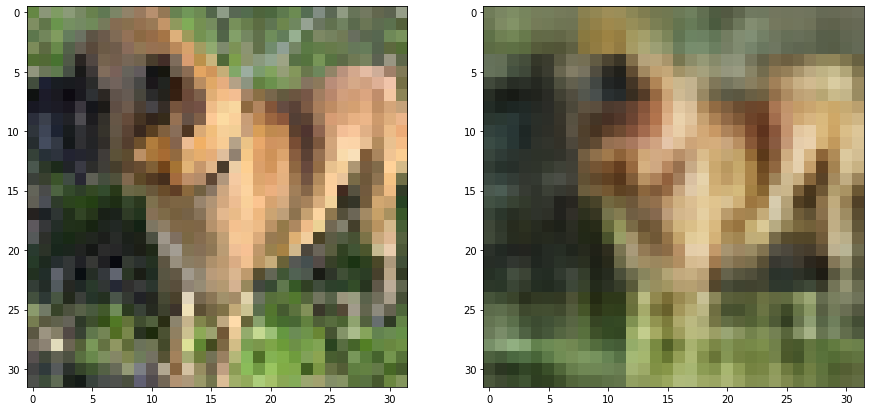

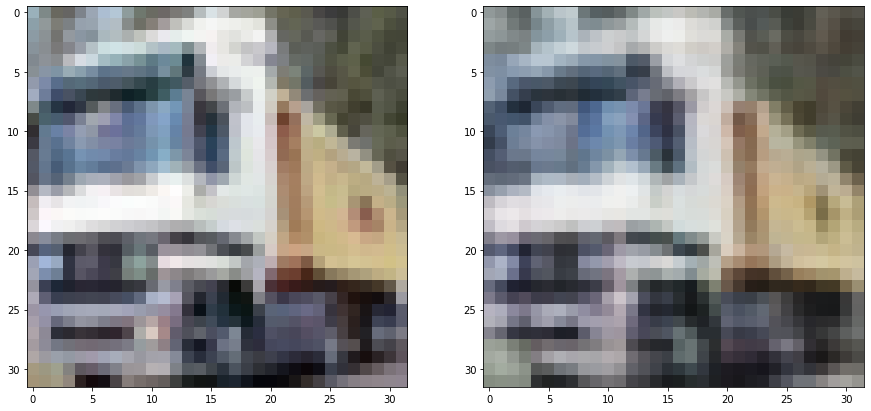

In [254]:
model.fit(x_train,x_train, epochs=10)
showPrediction(images[0])
showPrediction(x_train[1])

In [255]:
encodings = encoder.predict(x_test)
encodings = encodings.reshape((len(encodings),-1))
encodings.shape

(10000, 512)

In [256]:
m,n = 14,14
x_shrink = np.zeros((len(x_test),m*n*3))
for i in range(len(x_test)):
    im = cv2.resize(x_test[i], (m,n))
    x_shrink[i] = im.reshape((-1,))
x_shrink.shape

(10000, 588)

In [148]:
def testClusters(clusters):
    return adjusted_rand_score(y_test.reshape((-1,)), clusters)

def testEncodings(encodings):
    print('calculating k means...')
    k_clusters = KMeans(10).fit_predict(encodings)
    print('calculating agglomerative clustering...')
    a_clusters = AgglomerativeClustering(10).fit_predict(encodings)
    print(f'K Means Score: {testClusters(k_clusters)}')
    print(f'Agglomerative Score: {testClusters(a_clusters)}')

In [257]:
testEncodings(encodings)

calculating k means...
calculating agglomerative clustering...
K Means Score: 0.05121797471848084
Agglomerative Score: 0.0414138296782851


In [258]:
testEncodings(x_shrink)

calculating k means...
calculating agglomerative clustering...
K Means Score: 0.043441714523847194
Agglomerative Score: 0.03714055282060791


In [187]:
testEncodings(np.random.rand(len(x_shrink),1))

calculating k means...
calculating agglomerative clustering...
K Means Score: 6.702933005892877e-05
Agglomerative Score: 5.1254968977494434e-05


In [40]:
def showSample(images):
    fig = plt.figure(figsize=(10,10))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(in_cluster[np.random.randint(len(in_cluster))])
#     plt.tight_layout()
    fig.suptitle('cluster')

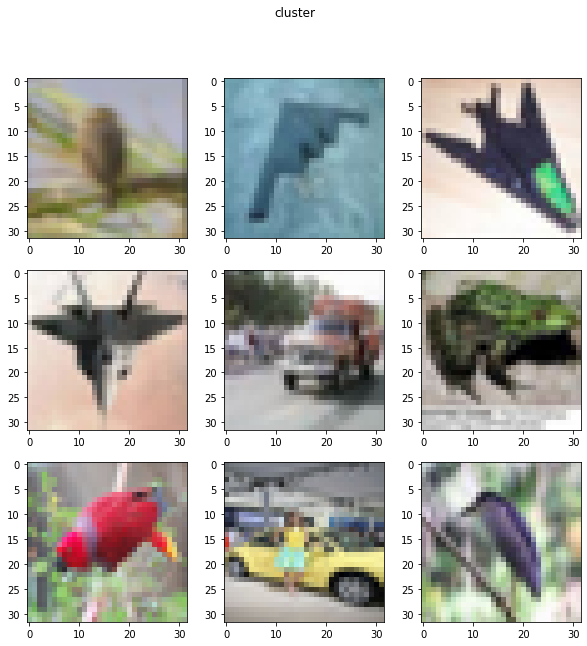

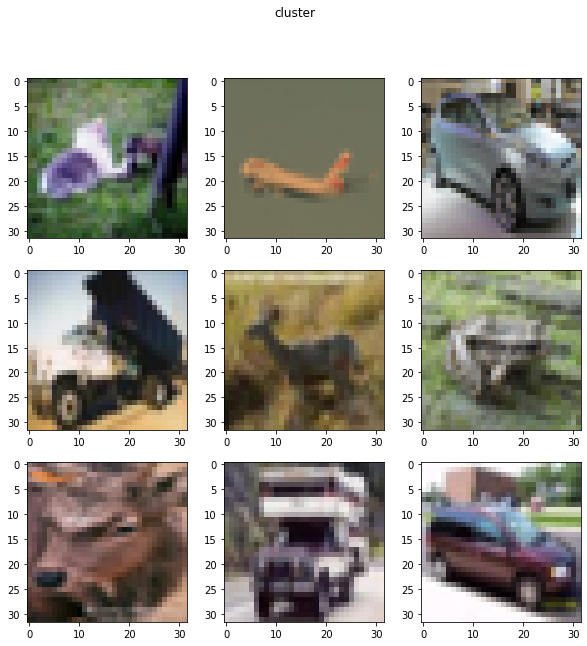

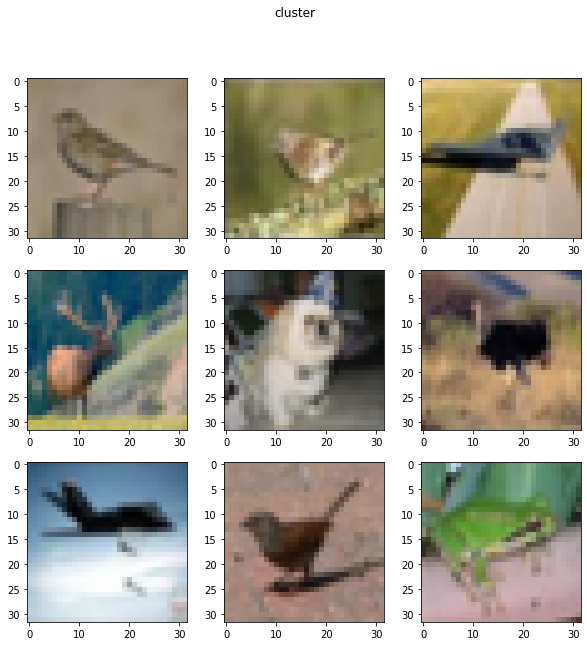

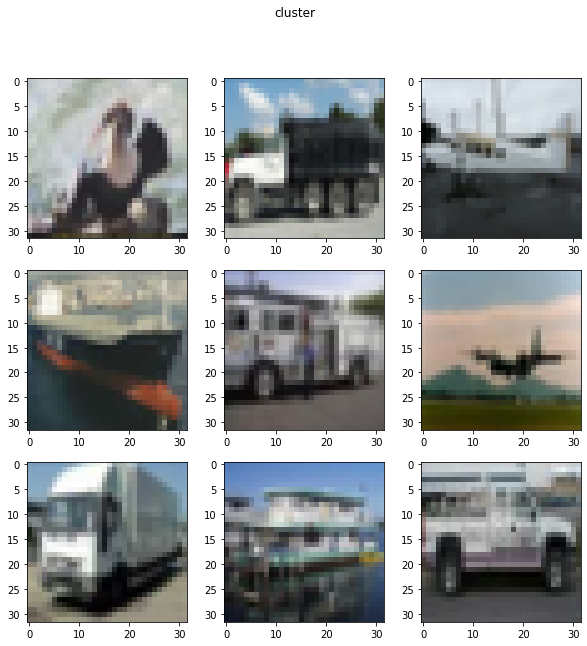

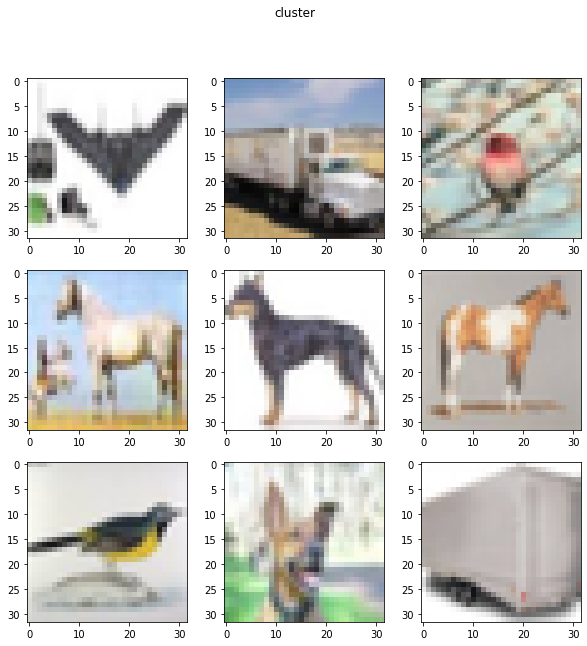

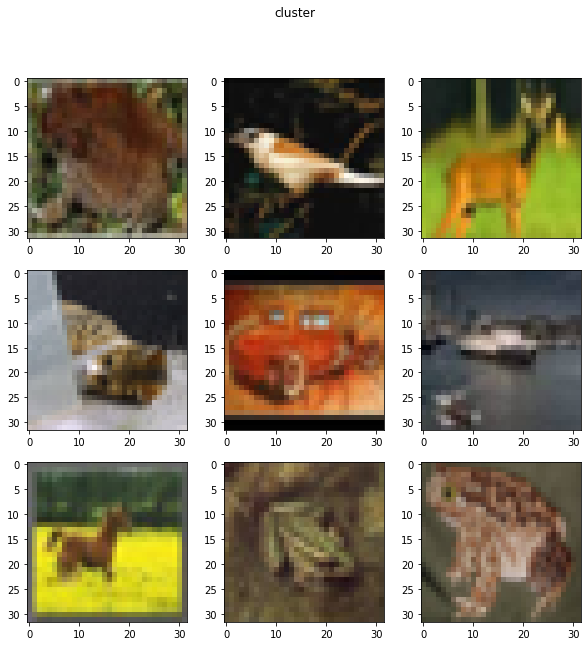

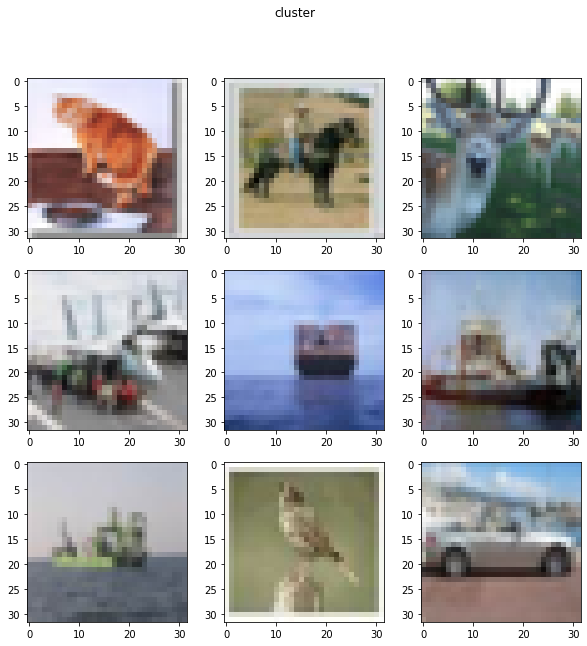

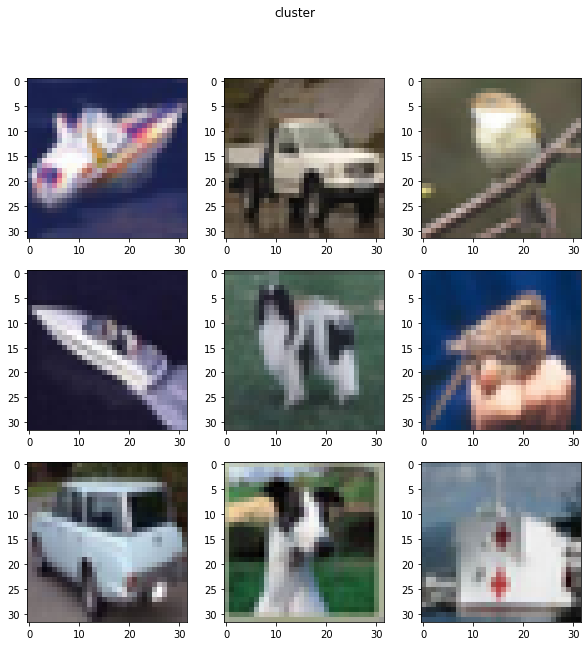

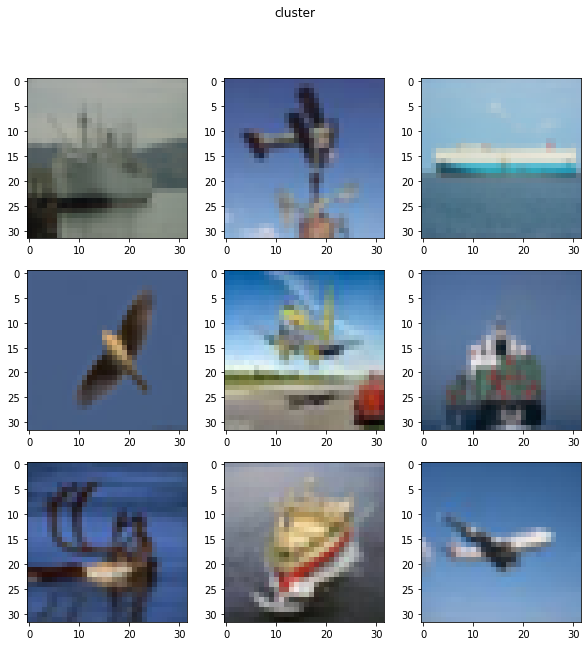

In [80]:
for i in range(9):
    showSample(x_test[a_clusters==i])